## Basic Imports & Settings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Shows matplotlib output below code cell instead of in a new window
%matplotlib inline

# Sets the default plot size to 12 inches wide by 6 inches tall
plt.rcParams['figure.figsize'] = (12,6)

## Load the dataset

In [2]:
# The local path to the F10.7 text file from Penticton, B.C., Canada
file_path = './datasets/f107.txt'

# Declare feature (col) names
cols = [
    "fluxdate", "fluxtime", "fluxjulian", "fluxcarrington",
    "fluxobsflux", "fluxadjflux", "fluxursi"
]

df = pd.read_csv(file_path, sep='\\s+', comment='#', header=None, names=cols)

# Convert date
df["date"] = pd.to_datetime(df["fluxdate"], format="%Y%m%d", errors="coerce")

# Force numeric conversion (turns strings like "000130.9" into 130.9 floats)
df["fluxadjflux"] = pd.to_numeric(df["fluxadjflux"], errors="coerce")

# Group by date (averaging the 3 daily measurements into one)
df = df.groupby("date", as_index=False)["fluxadjflux"].mean()

# Preview result
df.head(10)

,date,fluxadjflux
0,2004-10-28,132.450000
1,2004-10-29,130.550000
2,2004-10-30,139.466667
3,2004-10-31,137.200000
4,2004-11-01,132.700000
5,2004-11-02,131.200000
6,2004-11-03,135.200000
7,2004-11-04,138.133333
8,2004-11-05,135.266667
9,2004-11-06,125.366667


## Visualize the dataset

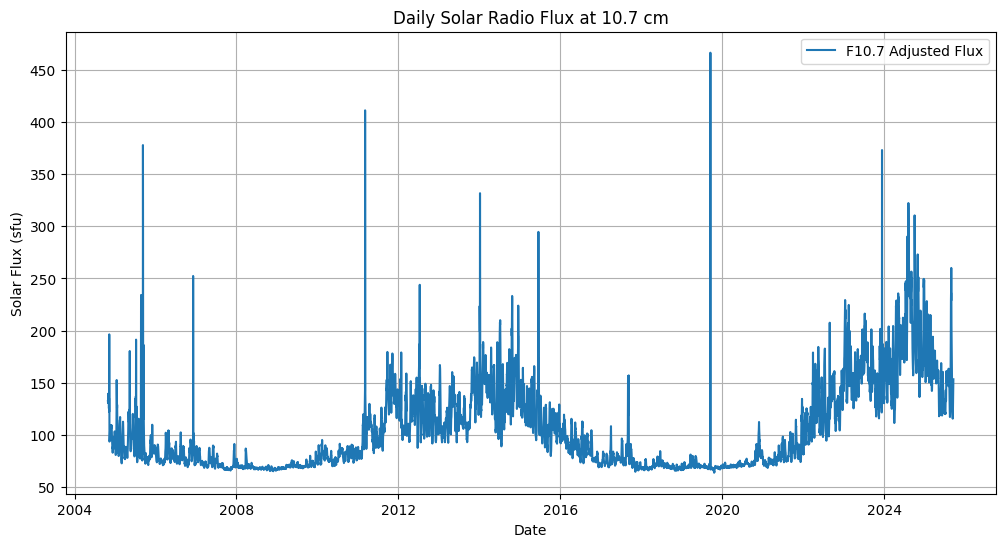

In [3]:
# Quick time series plot
plt.figure(figsize=(12,6))
plt.plot(df["date"], df["fluxadjflux"], label="F10.7 Adjusted Flux")
plt.xlabel("Date")
plt.ylabel("Solar Flux (sfu)")
plt.title("Daily Solar Radio Flux at 10.7 cm")
plt.legend()
plt.grid(True)
plt.show()


# Benchmark: Persistance Baseline

## Forecast Performance Baseline
A baseline in forecast performance provides a point of comparison. Think of it like a "minimum performance bar."

## Persistance Model
The most common baseline for time series forecasting.
It follows the rule that "The future will be the same as the present."

### Persistence Algorithm (the “naive” forecast)
>The persistence algorithm uses the value at the previous time step (t-1) to predict the expected outcome at the next time step (t+1).

For 7-days ahead: predict F10.7 in 7 days = today’s value.

### Why persistance works
- In time series forecasting, values are often autocorrelated, meaning tomorrow tends to look like today, next week tends to look like this week.
- For F10.7, the daily values don’t vary too much most of the time. They change slowly, with bumps from active regions and flares.


*Source: https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/*

# First Prediction Attempt: 7 Days

## Adjust dataframe for 7 day prediction

In [4]:
# Make a copy of the dataframe for 7 day prediction
data7 = df.copy()

# Create the target (label): flux 7 days in the future
    # EX: For date JAN 1: X -> JAN 1 Flux ; Y -> JAN 8 Flux
data7['target_flux'] = data7['fluxadjflux'].shift(-7)

# Add lag features: flux from the past 27 days (For LR)
for lag in range(1, 28):  # lag1 through lag27
    data7[f"lag{lag}"] = data7["fluxadjflux"].shift(lag)

# Drop the rows without labels (NaN) (happens because we are shifting the data by 7 days)
data7 = data7.dropna()

# Quick peek
data7.head(10)

,date,fluxadjflux,target_flux,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27
27,2004-11-24,105.433333,108.866667,105.766667,103.766667,99.000000,97.466667,101.133333,102.900000,103.233333,...,125.366667,135.266667,138.133333,135.200000,131.200000,132.700000,137.200000,139.466667,130.550000,132.450000
28,2004-11-25,106.933333,102.466667,105.433333,105.766667,103.766667,99.000000,97.466667,101.133333,102.900000,...,135.100000,125.366667,135.266667,138.133333,135.200000,131.200000,132.700000,137.200000,139.466667,130.550000
29,2004-11-26,109.333333,98.166667,106.933333,105.433333,105.766667,103.766667,99.000000,97.466667,101.133333,...,122.000000,135.100000,125.366667,135.266667,138.133333,135.200000,131.200000,132.700000,137.200000,139.466667
30,2004-11-27,107.633333,94.533333,109.333333,106.933333,105.433333,105.766667,103.766667,99.000000,97.466667,...,196.400000,122.000000,135.100000,125.366667,135.266667,138.133333,135.200000,131.200000,132.700000,137.200000
31,2004-11-28,109.100000,93.633333,107.633333,109.333333,106.933333,105.433333,105.766667,103.766667,99.000000,...,103.533333,196.400000,122.000000,135.100000,125.366667,135.266667,138.133333,135.200000,131.200000,132.700000
32,2004-11-29,108.966667,90.200000,109.100000,107.633333,109.333333,106.933333,105.433333,105.766667,103.766667,...,93.533333,103.533333,196.400000,122.000000,135.100000,125.366667,135.266667,138.133333,135.200000,131.200000
33,2004-11-30,106.933333,87.466667,108.966667,109.100000,107.633333,109.333333,106.933333,105.433333,105.766667,...,94.233333,93.533333,103.533333,196.400000,122.000000,135.100000,125.366667,135.266667,138.133333,135.200000
34,2004-12-01,108.866667,87.866667,106.933333,108.966667,109.100000,107.633333,109.333333,106.933333,105.433333,...,95.000000,94.233333,93.533333,103.533333,196.400000,122.000000,135.100000,125.366667,135.266667,138.133333
35,2004-12-02,102.466667,84.833333,108.866667,106.933333,108.966667,109.100000,107.633333,109.333333,106.933333,...,97.700000,95.000000,94.233333,93.533333,103.533333,196.400000,122.000000,135.100000,125.366667,135.266667
36,2004-12-03,98.166667,82.866667,102.466667,108.866667,106.933333,108.966667,109.100000,107.633333,109.333333,...,103.566667,97.700000,95.000000,94.233333,93.533333,103.533333,196.400000,122.000000,135.100000,125.366667


#### Baseline Evaluation

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Baseline persistence: predict that 7-day ahead flux = today's flux
data7["baseline_pred"] = data7["fluxadjflux"]

# Evaluate errors
mae = mean_absolute_error(data7["target_flux"], data7["baseline_pred"])
rmse = np.sqrt(mean_squared_error(data7["target_flux"], data7["baseline_pred"]))

print(f"Baseline 7-day Persistence MAE: {mae:.2f} sfu")
print(f"Baseline 7-day Persistence RMSE: {rmse:.2f} sfu")

Baseline 7-day Persistence MAE: 12.79 sfu
Baseline 7-day Persistence RMSE: 23.40 sfu


#### Recent (Last 90 days) Evaluation

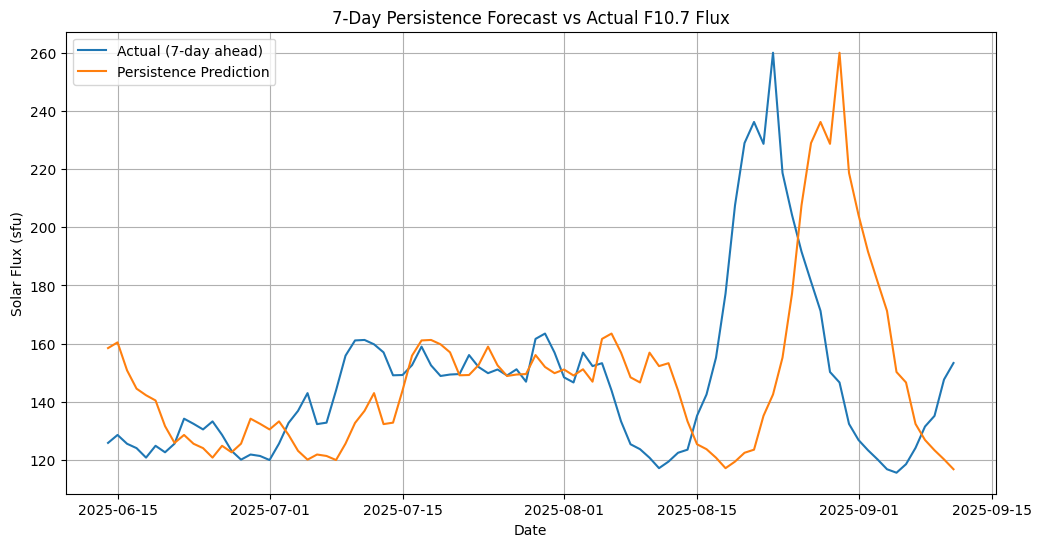

In [6]:
# Compare actual vs persistence prediction over the last 90 days
recent = data7.tail(90)

plt.figure(figsize=(12,6))
plt.plot(recent["date"], recent["target_flux"], label="Actual (7-day ahead)")
plt.plot(recent["date"], recent["baseline_pred"], label="Persistence Prediction")
plt.xlabel("Date")
plt.ylabel("Solar Flux (sfu)")
plt.title("7-Day Persistence Forecast vs Actual F10.7 Flux")
plt.legend()
plt.grid(True)
plt.show()


#### Takeaways
The 7-day persistence model provides a useful baseline for evaluating forecasting methods. It performs reasonably well during periods of low solar activity but fails to anticipate sudden spikes, leading to higher error. Persistence is not a true predictive model, but it establishes a benchmark that future ML models should aim to surpass.

Two error metrics are reported:
- **MAE (Mean Absolute Error):** average size of the forecast error, easy to interpret in the same units (sfu).
- **RMSE (Root Mean Squared Error):** penalizes larger mistakes more heavily, so it highlights the model’s weakness on sudden solar activity spikes.

Together, MAE shows the typical forecast miss, while RMSE emphasizes how badly the baseline fails during extreme events.


## Model 1: Linear Regression

Linear Regression is one of the simplest ML models, working very fast. It acts as a great model to begin with.

This model will utilize **lag features**. Lag features simply represent a value for a number of rows (days) behind.

For example, "lag1" would represent the flux from the day before, "lag7" a week before, and so on.

In [7]:
from sklearn.linear_model import LinearRegression

# Features (lags), target
features = [f"lag{lag}" for lag in range(1, 28)]
target = "target_flux"

X = data7[features]
y = data7[target]

# Split the data into training + testing set (70/30)
split = int(0.7* len(data7))

X_train, X_test = X.iloc[:split], X.iloc[split:]

y_train, y_test = y.iloc[:split], y.iloc[split:]

# Training the model
model = LinearRegression()
model.fit(X_train, y_train)

# Run predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the predictions
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Linear Regression (lags 1–7) MAE:", mae)
print("Linear Regression (lags 1–7) RMSE:", rmse)

Linear Regression (lags 1–7) MAE: 13.756383352263766
Linear Regression (lags 1–7) RMSE: 22.715019455233232


### Model 1: Linear Regression with Lag Features

We trained a simple **Linear Regression model** using the past 27 days of flux values (`lag1` … `lag27`) to predict the flux **7 days into the future** (`target_flux`).  

This approach allows the model to "see" an entire solar rotation (~27 days), giving it more context than persistence, which only assumes today’s value = 7 days later.

### Visualization: Predicted vs Actual Flux

To evaluate the model’s performance, we compare its predictions against the actual flux values on the test set.  
- A scatter or line plot will show how well predictions align with reality.  
- We’ll also plot the **persistence forecast** for direct comparison.

Key questions:  
- Does the model capture overall trends?  
- Does it reduce large spike errors compared to persistence?  
- Where does it still struggle?

### Performance Summary

- **Persistence baseline**:  
  - MAE ≈ **12.8**  
  - RMSE ≈ **23.4**  

- **Linear Regression (lags 1–27)**:  
  - MAE ≈ **13.8**  
  - RMSE ≈ **22.7**  

**Takeaways**  
- The regression model slightly underperforms persistence on **MAE** (average error).  
- However, it improves on **RMSE**, meaning it does a better job at handling *large spikes*, which persistence fails at completely.  
- This is promising: the model has learned something about the solar rotation cycle, but it is still too simple to consistently outperform persistence overall.  

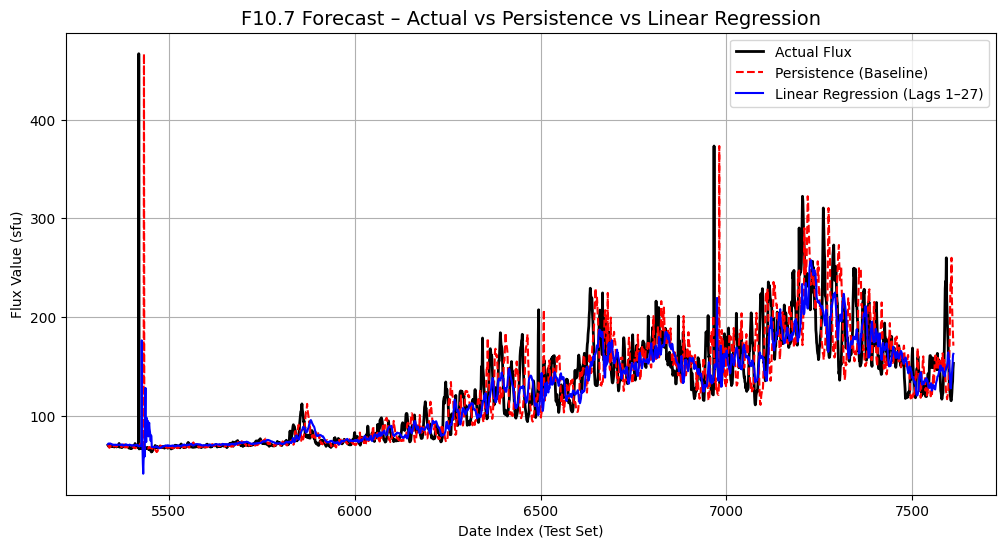

In [8]:

# --- Persistence baseline for comparison ---
# Persistence says: flux 7 days later = today's flux
y_persistence = X_test["lag7"]  # because lag7 = value 7 days ago relative to target

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label="Actual Flux", color="black", linewidth=2)
plt.plot(y_test.index, y_persistence.values, label="Persistence (Baseline)", linestyle="--", color="red")
plt.plot(y_test.index, y_pred, label="Linear Regression (Lags 1–27)", linestyle="-", color="blue")

plt.title("F10.7 Forecast – Actual vs Persistence vs Linear Regression", fontsize=14)
plt.xlabel("Date Index (Test Set)")
plt.ylabel("Flux Value (sfu)")
plt.legend()
plt.grid(True)
plt.show()

### Plot Interpretation

This plot compares **Actual F10.7 flux** (black), the **Persistence forecast** (red dashed), and the **Linear Regression model** (blue).  

Observations:
- **Persistence**: Tracks well during quiet periods but completely misses sudden spikes, leading to large errors.  
- **Linear Regression**: Shows some improvement in handling large deviations (lower RMSE than persistence), but still lags behind on average daily accuracy (higher MAE).  
- **Overall**: The regression model has started to capture patterns from the 27-day solar rotation, but its simplicity limits performance.  

This visualization confirms our metrics:
- **MAE** is slightly worse than persistence (model struggles with average day-to-day accuracy).  
- **RMSE** is slightly better than persistence (model reduces the worst spike errors).  

This first model provides a valuable benchmark: simple regression can capture some cyclical signal, but we’ll need additional features and/or more advanced models to consistently outperform persistence across all conditions.


## Model 2: SARIMA

### Seasonal Autoregressive Integrated Moving Average
>An extension of the traditional ARIMA model, specifically designed for time series data with seasonal patterns. While ARIMA is great for non-seasonal data, SARIMA introduces seasonal components to handle periodic fluctuations and provides better forecasting capabilities for seasonal data.

- S (Seasonal): repeats AR/MA terms across a seasonal period (in our case ~27 days).
- AR (AutoRegressive): predicts today from a weighted sum of past days.
- I (Integrated): differencing the series to remove trends.
- MA (Moving Average): models the error (shocks/spikes) as a weighted sum of past errors.

> The SARIMA model is represented as:
> 
> `SARIMA(p, d, q)(P, D, Q, s)`
> 
> **Parameters:**
> - **p**: Autoregressive order  
> - **d**: Number of non-seasonal differences  
> - **q**: Moving average order  
> - **P**: Seasonal autoregressive order  
> - **D**: Seasonal differencing order  
> - **Q**: Seasonal moving average order  
> - **s**: Length of the seasonal period (e.g., 12 for monthly data, ~27 for solar rotation)


So SARIMA can “remember” both short-term lags and repeating seasonal patterns.

*Source: https://www.geeksforgeeks.org/machine-learning/sarima-seasonal-autoregressive-integrated-moving-average/*

In [9]:
# Converts dataframe to a series
series = df.set_index("date")["fluxadjflux"]

# Assign daily frequency (since F10.7 is daily)
series = series.asfreq("D")

# Split into training + testing sets
split = int(0.7 * len(series))
train, test = series.iloc[:split], series.iloc[split:]

import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(
    train,
    order=(2,1,2),
    seasonal_order=(1,1,1,27),
    enforce_stationarity=False,
    enforce_invertibility=False
)


results = model.fit(disp=True, maxiter=200)


In [13]:
# Convert and align
y_pred = y_pred.values if hasattr(y_pred, "values") else y_pred
y_true = test.values

n = min(len(y_true), len(y_pred))
y_true = y_true[:n]
y_pred = y_pred[:n]

mask = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask]
y_pred = y_pred[mask]

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("SARIMA MAE:", mae)
print("SARIMA RMSE:", rmse)

SARIMA MAE: 14.942567889954866
SARIMA RMSE: 24.682555968693997


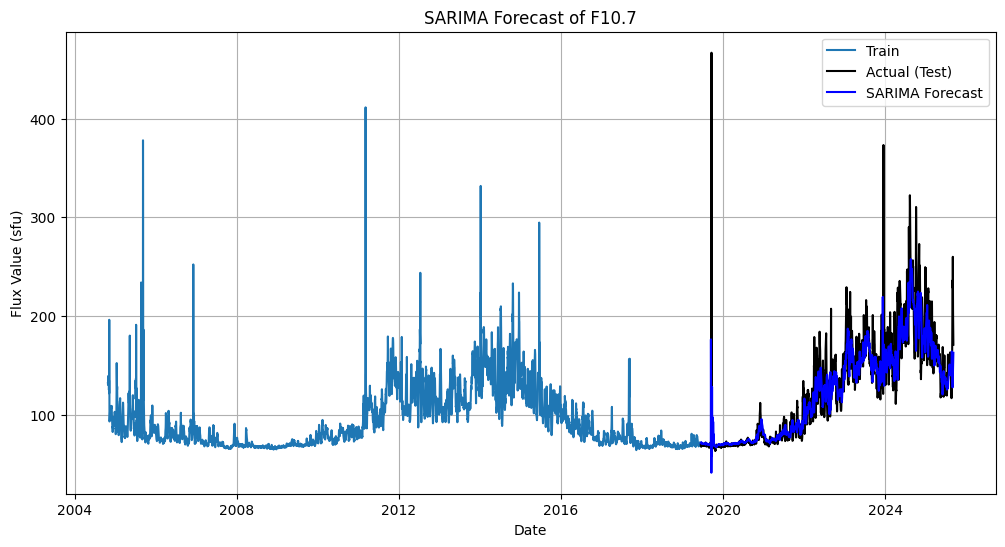

In [11]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test_index, y_true, label="Actual (Test)", color="black")
plt.plot(test_index, y_pred, label="SARIMA Forecast", color="blue")
plt.title("SARIMA Forecast of F10.7")b
plt.xlabel("Date")
plt.ylabel("Flux Value (sfu)")
plt.legend()
plt.grid(True)
plt.show()

### Model 2: SARIMA (Seasonal ARIMA)

We tested a **SARIMA model** with parameters `(2,1,2)(1,1,1,27)` to capture both short-term memory and the ~27-day solar rotation cycle.

---

**What is SARIMA?**  
SARIMA extends the traditional ARIMA model to handle seasonality.  
- **AR (AutoRegressive):** predicts today from past values.  
- **I (Integrated):** removes long-term trends by looking at changes instead of raw values.  
- **MA (Moving Average):** predicts today using past forecast errors.  
- **S (Seasonal):** repeats AR/MA terms across a seasonal cycle (here, ~27 days for solar rotation).  

The general form is:

`SARIMA(p, d, q)(P, D, Q, s)`

---

**Why these parameters?**

- **(p, d, q) = (2, 1, 2)**  
  - **p = 2:** Look back at the last 2 days of flux when making a prediction. This gives the model a short memory of recent changes.  
  - **d = 1:** Remove overall drift by focusing on changes (today minus yesterday) instead of raw flux values. This makes the data more stable.  
  - **q = 2:** Use the last 2 forecast errors (“mistakes”) to adjust predictions.  

- **(P, D, Q, s) = (1, 1, 1, 27)**  
  - **P = 1:** Use the flux value from one full solar rotation ago (~27 days).  
  - **D = 1:** Remove repeating seasonal drift so the model focuses on true cyclical patterns.  
  - **Q = 1:** Use the forecast error from one rotation ago to improve current predictions.  
  - **s = 27:** The seasonal cycle length is 27 days, matching the Sun’s rotation.  

In plain terms: this setup tells the model to use the **last 2 daily values**, the **last 2 mistakes**, and the **values and mistakes from one 27-day cycle ago** to make a forecast. We also remove linear and seasonal drift to make the data easier to model.

---

**Results (this run):**  
- MAE ≈ 14.9  
- RMSE ≈ 24.7  
- Forecasts followed broad solar cycle trends but smoothed out spikes.  

---

**Takeaways:**  
- SARIMA, when tuned for the ~27-day solar cycle, can follow long-term cycles better than persistence, but still fails to capture sudden flux spikes.  
- It underperformed compared to the persistence and regression baselines in terms of MAE and RMSE.  
- This demonstrates the limitation of traditional time-series models for highly variable, spike-driven data like F10.7.  
- Next step: move to **nonlinear ML models** (Random Forest, Neural Networks) that can better capture complex patterns. Step away from statistical models.

